# Creating Models

One of the main goals of BIDMat/BIDMach is to make model creation, customization and experimentation much easier. 

To that end is has reusable classes that cover the elements of Learning:

* Model: The core class for a learning algorithm, and often the only one you need to implement.
* DataSource: A source of data, like an in-memory matrix, a set of files (possibly on HDFS) or a data iterator (for Spark).
* DataSink: A target for data such as predictions, like an in-memory matrix, a set of files, or an iterator. 
* Updaters: Update a model using minibatch update from a Model class. Includes SGD, ADAGRAD, Monte-Carlo updates, and multiplicative updates. 
* Mixins: Secondary Loss functions that are added to the global gradient. Includes L1 and L2 regularizers, cluster quality metrics, factor model metrics. 
* Learner: Combines the classes above and provides high-level control over the learning process: iterations, stop/start/resume

When creating a new model, its often only necessary to creat a new model class. We recently needed a scalable SVD (Singular Value Decomposition) for some student projects. Lets walk through creating this from scratch. 

# Scalable SVD

This model works like the previous example of in-memory SVD for a matrix M. The singular values of M are the eigenvalues of M M^T so we do subspace iteration: 

$$P = M M^T Q$$
$$(Q,R) = QR(P)$$

But now we want to deal with an M which is too big to fit in memory. In the minibatch context, we can write M as a horizontal concatenation of mini-batches (this assumes data samples are columns of M and features are rows):

$$M = M_1 M_2 \cdots M_n$$

and then $$P = \sum_{i=1}^n M_i M_i^T Q$$

so we can compute $P$ by operating only on the minibatches $M_i$. We need to be able to fit $P$ and $Q$ in memory, their size is only $k~ |F|$ where $k$ is the SVD dimension and $F$ is the feature set. 

### Model Class

We start by defining a new model class which extends BIDMach's Model class. It will always take an Options instance as an argument:

<b>
<code style="color:blue">
class SVD(opts:SVD.Opts = new SVD.Options) extends Model(opts)
</code>
</b>

The options are defined in the "Object" associated with the class. In Scala "Object" defines a singleton which holds all of the static methods of the class. It looks like this:

<b><code style="color:blue">
object SVD  {
  trait Opts extends Model.Opts {
    var deliciousness = 3
  }
  
  class Options extends Opts {}
  ...
</code></b>

Truthfully, an SVD model doesnt need a "deliciousness" option, in fact it doesnt need any Options at all - or rather what it needs is inherited from its parent. But its there to show how options are created. The Opts are defined as a trait rather than a class so they can be mixed in with the Options of other learning classes. 

### Local Variables and Initialization

There are three variables we need to keep track of:

<b><code style="color:blue">
  var Q:Mat = null;                                        // (Left) Singular vectors
  var SV:Mat = null;                                       // Singular values
  var P:Mat = null;                                        // P (accumulator)
</code></b>

and an initialization routine sets these to appropriate values.

### Minibatch Update

Each update should update the stable model: Here its $P$:

<b><code style="color:blue">
  def dobatch(mats:Array[Mat], ipass:Int, pos:Long):Unit = {
    val M = mats(0);
    P ~ P + (Q.t &ast; M &ast;&#94; M).t                               // Compute P = M &ast; M&#94;t &ast; Q efficiently
  }
</code></b>

### Score Batches

The score method should return a floating point vector of scores for this minibatch.

<b><code style="color:blue">
  def evalbatch(mat:Array[Mat], ipass:Int, pos:Long):FMat = {
    SV ~ P ∙ Q;                                            // Estimate the singular values
    val diff = (P / SV) - Q;                               // residual
    row(-(math.sqrt(norm(diff) / diff.length)));           // return the norm of the residual
  }
</code></b>

### Update the Model

At the end of a pass over the data, we update $Q$. Not all models need this step, and minibatch algorithms typically dont have it. 

<b><code style="color:blue">
  override def updatePass(ipass:Int) = {   
    QRdecompt(P, Q, null);                                 // Basic subspace iteration
    P.clear;                                               // Clear P for the next pass
  }
</code></b>

### Convenience Functions

We're done defining the SVD model. We can run it now, but to make that easier we'll define a couple of convenience functions.

### An in-memory Learner

<b><code style="color:blue">
  class MatOptions extends Learner.Options with SVD.Opts with MatSource.Opts with Batch.Opts
  
  def learner(mat:Mat):(Learner, MatOptions) = { 
    val opts = new MatOptions;
    opts.batchSize = math.min(100000, mat.ncols/30 + 1)
  	val nn = new Learner(
  	    new MatSource(Array(mat), opts), 
  			new SVD(opts), 
  			null,
  			new Batch(opts), 
  			null,
  			opts)
    (nn, opts)
  }
</code></b>

### A File-based Learner

<b><code style="color:blue">
  class FileOptions extends Learner.Options with SVD.Opts with FileSource.Opts with Batch.Opts
  
  def learner(fnames:String):(Learner, FileOptions) = { 
    val opts = new FileOptions;
    opts.batchSize = 10000;
    opts.fnames = List(FileSource.simpleEnum(fnames, 1, 0));
    implicit val threads = threadPool(4);
  	val nn = new Learner(
  	    new FileSource(opts), 
  			new SVD(opts), 
  			null,
  			new Batch(opts), 
  			null,
  			opts)
    (nn, opts)
  }
</code></b>

### A Predictor

A predictor is a Learner which runs an existing model over a DataSource and outputs to a DataSink. For SVD, the predictor outputs the right singular vectors, which may be too large to fit in memory. Here's a memory-to-memory predictor:

<b><code style="color:blue">
 class PredOptions extends Learner.Options with SVD.Opts with MatSource.Opts with MatSink.Opts;
  
  // This function constructs a predictor from an existing model 
  def predictor(model:Model, mat1:Mat):(Learner, PredOptions) = {
    val nopts = new PredOptions;
    nopts.batchSize = math.min(10000, mat1.ncols/30 + 1)
    nopts.dim = model.opts.dim;
    val newmod = new SVD(nopts);
    newmod.refresh = false
    model.copyTo(newmod)
    val nn = new Learner(
        new MatSource(Array(mat1), nopts), 
        newmod, 
        null,
        null,
        new MatSink(nopts),
        nopts)
    (nn, nopts)
  }
</code></b>

## Testing

Now lets try it out! First we initialize BIDMach as before.

In [1]:
import BIDMat.{CMat,CSMat,DMat,Dict,IDict,FMat,FND,GDMat,GMat,GIMat,GLMat,GSDMat,GSMat,
               HMat,IMat,Image,LMat,Mat,SMat,SBMat,SDMat}
import BIDMat.MatFunctions._
import BIDMat.SciFunctions._
import BIDMat.Solvers._
import BIDMat.Plotting._
import BIDMach.Learner
import BIDMach.models.{FM,GLM,KMeans,KMeansw,ICA,LDA,LDAgibbs,Model,NMF,RandomForest,SFA,SVD}
import BIDMach.datasources.{DataSource,MatSource,FileSource,SFileSource}
import BIDMach.mixins.{CosineSim,Perplexity,Top,L1Regularizer,L2Regularizer}
import BIDMach.updaters.{ADAGrad,Batch,BatchNorm,IncMult,IncNorm,Telescoping}
import BIDMach.causal.{IPTW}

Mat.checkMKL
Mat.checkCUDA
Mat.inline = true
if (Mat.hasCUDA > 0) GPUmem

1 CUDA device found, CUDA version 7.0


(0.8005314,3438256128,4294967296)

We'll run on the MNIST 8M (8 millon images) digit data, which is a large dataset distributed over multiple files

In [2]:
val dir="../data/MNIST8M/parts/"
val (nn, opts) = SVD.learner(dir+"data%02d.fmat.lz4");

Let's set some options:

In [3]:
opts.nend = 10;
opts.dim = 20;
opts.npasses = 4;
opts.batchSize = 50000;

and release the beast:

In [4]:
nn.train

pass= 0
10.00%, ll=   NaN, gf=3.708, secs=0.8, GB=0.31, MB/s=370.69, GPUmem=0.757456
64.00%, ll=   NaN, gf=11.964, secs=2.9, GB=2.04, MB/s=706.80, GPUmem=0.757456
100.00%, ll=   NaN, gf=13.298, secs=4.0, GB=3.14, MB/s=782.04, GPUmem=0.757456
pass= 1
10.00%, ll=   NaN, gf=12.843, secs=4.4, GB=3.45, MB/s=784.71, GPUmem=0.757456
64.00%, ll=   NaN, gf=15.699, secs=5.6, GB=5.17, MB/s=924.99, GPUmem=0.757456
100.00%, ll=   NaN, gf=17.089, secs=6.2, GB=6.27, MB/s=1005.13, GPUmem=0.757456
pass= 2
10.00%, ll=   NaN, gf=15.799, secs=6.9, GB=6.59, MB/s=947.84, GPUmem=0.754042
64.00%, ll=   NaN, gf=15.746, secs=9.0, GB=8.31, MB/s=927.19, GPUmem=0.754042
100.00%, ll=   NaN, gf=15.844, secs=10.1, GB=9.41, MB/s=931.95, GPUmem=0.754042
pass= 3
10.00%, ll=   NaN, gf=15.600, secs=10.5, GB=9.72, MB/s=929.94, GPUmem=0.754042
64.00%, ll=   NaN, gf=16.669, secs=11.7, GB=11.45, MB/s=981.26, GPUmem=0.754042
100.00%, ll=   NaN, gf=17.298, secs=12.3, GB=12.54, MB/s=1017.44, GPUmem=0.754042
Time=12.3300 secs, gf

The model matrices for this model hold the results. They are generic matrices, so we cast them to FMats:

In [5]:
val svals = FMat(nn.modelmats(1));
val svecs = FMat(nn.modelmats(0))(?,(opts.dim - 1) to 0 by -1);

To see how well we did, we will compute the SVD directly by computing M M^T and computing its eigendecomposition. Normally we can't do this because MM^T is nfeats x nfeats, but for this dataset nfeats is only 784. 

In [6]:
val MMt = zeros(784,784);
for (i <- 0 until opts.nend) {
val Mi = loadFMat(dir+"data%02d.fmat.lz4" format i);
MMt ~ Mi *^ Mi;
print(".");
} 
println;

..........


Now we call an eigenvalue routine to compute the eigenvalues and eigenvectors of MMt, which are the singular values and left singular vectors of M. 

In [7]:
val (eval, evecs) = feig(MMt);
val topvecs = evecs(?, 783 to 784-opts.dim by -1);

Eigenvectors have a sign ambiguity, and its common to see V or -V. So next we compute dot products between the two sets of vectors and flip signs if a dot product is negative:

In [8]:
val dots = svecs ∙ topvecs;
topvecs ~ topvecs ∘ (2*(dots>0) - 1);

Lets now look at the eigenvectors as small images, decreasing in strength from left to right. First the reference eigenvectors:

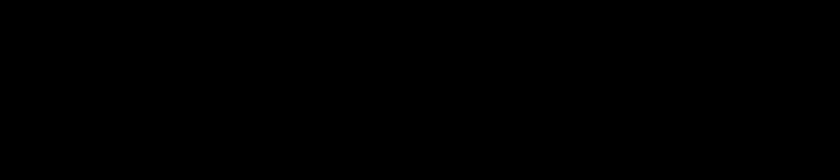

In [9]:
val onerow = svecs.view(28,28*opts.dim);
val nc = onerow.ncols;
val tworows = onerow(?,0->(nc/2)) on onerow(?,(nc/2)->nc)
show((tworows.t*500+128) ⊗ ones(3,3))

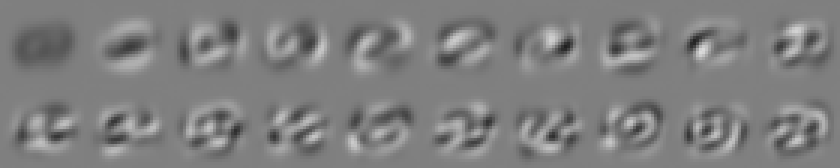

In [10]:
val onerow = topvecs.view(28,28*opts.dim);
val nc = onerow.ncols;
val tworows = onerow(?,0->(nc/2)) on onerow(?,(nc/2)->nc)
show((tworows.t*500+128) ⊗ ones(3,3))